# Building a model which classifies a close up (zoomed) image from normal product images in Flipkart

## Samples for close up zoomed images

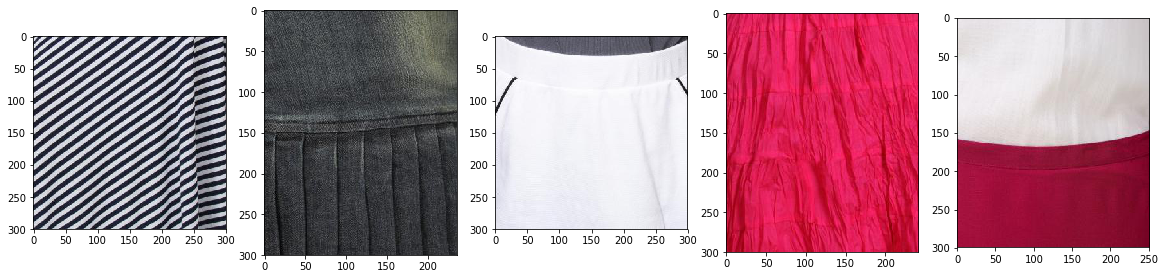

In [34]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

images = []
for img_path in glob.glob('dataset/zoomed/*.jpg'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)

## Samples for normal product images

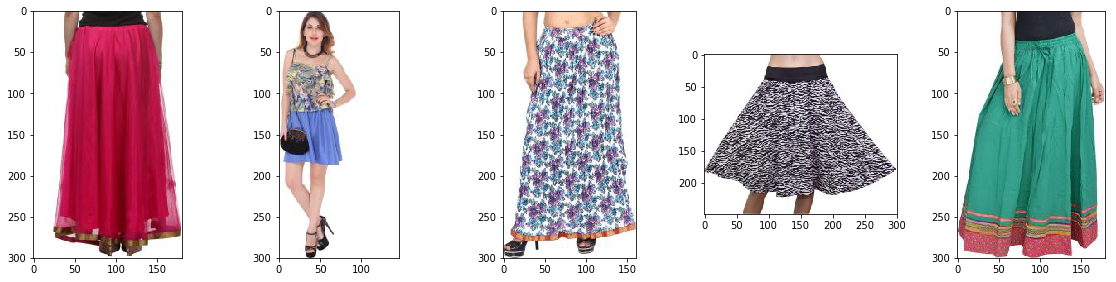

In [38]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

images = []
for img_path in glob.glob('dataset/normal/*.jpg'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)

In [18]:
import cv2
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage import data
from skimage.color import label2rgb

# settings for LBP
radius = 3
n_points = 8 * radius


def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)


def highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')

def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(lbp.ravel(), normed=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5')

def plot_histograms(image_path):
    im = cv2.imread(image_path)
    image = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(image, n_points, radius, METHOD)

    # plot histograms of LBP of textures
    fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
    plt.gray()

    titles = ('edge', 'flat', 'corner')
    w = width = radius - 1
    edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
    flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
    i_14 = n_points // 4            # 1/4th of the histogram
    i_34 = 3 * (n_points // 4)      # 3/4th of the histogram
    corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                     list(range(i_34 - w, i_34 + w + 1)))

    label_sets = (edge_labels, flat_labels, corner_labels)

    for ax, labels in zip(ax_img, label_sets):
        ax.imshow(overlay_labels(image, lbp, labels))

    for ax, labels, name in zip(ax_hist, label_sets, titles):
        counts, _, bars = hist(ax, lbp)
        highlight_bars(bars, labels)
        ax.set_ylim(ymax=np.max(counts[:-1]))
        ax.set_xlim(xmax=n_points + 2)
        ax.set_title(name)

    ax_hist[0].set_ylabel('Percentage')
    for ax in ax_img:
        ax.axis('off')

## Plotting histograms for close up Images to detect patterns in histograms

/home/girish/anaconda3/envs/movievibes/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


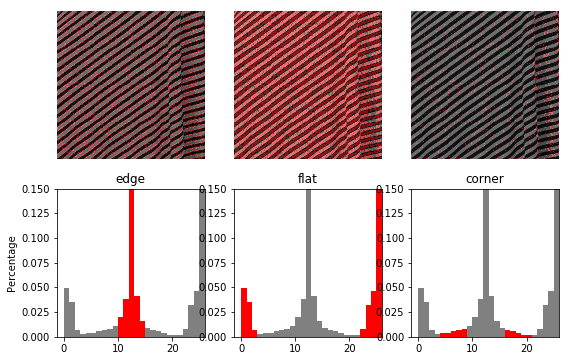

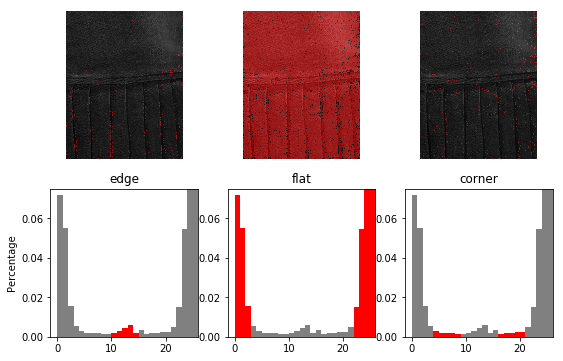

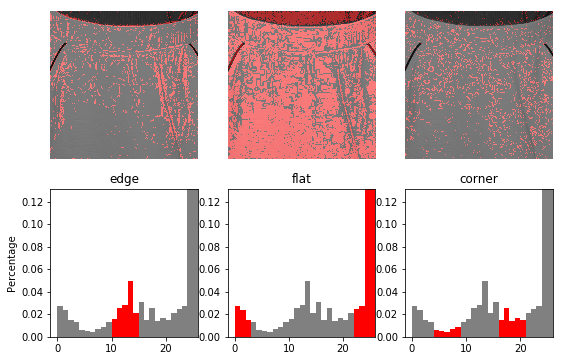

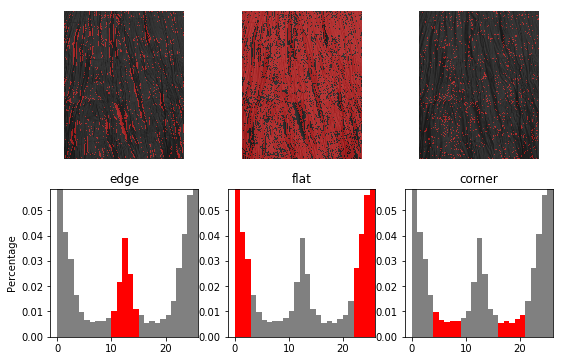

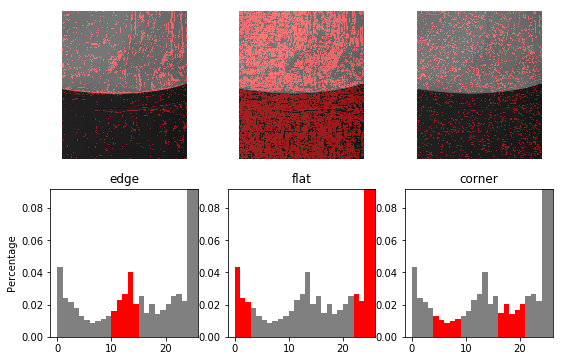

In [39]:
for image in glob.glob('dataset/zoomed/*.jpg'):
    plot_histograms(image)

## Plotting histograms for normal Images to detect patterns in histograms

/home/girish/anaconda3/envs/movievibes/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


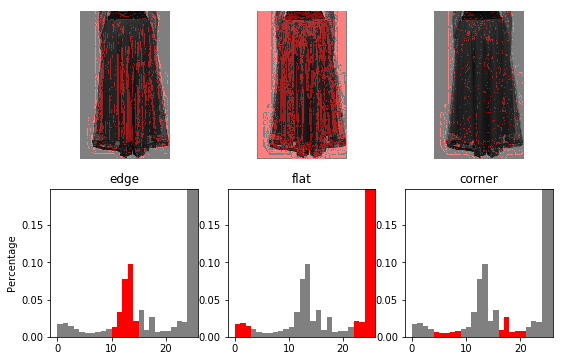

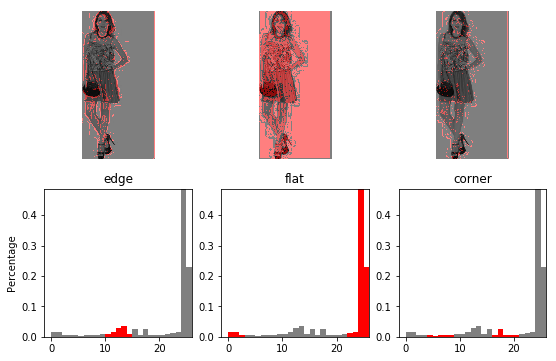

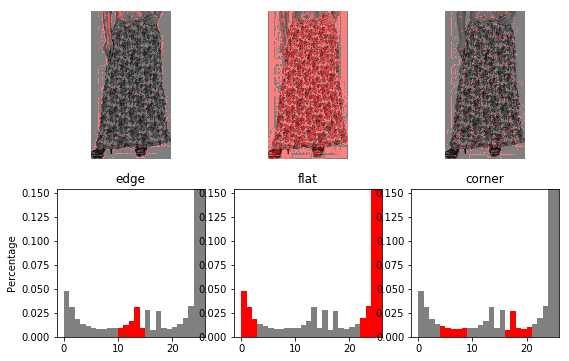

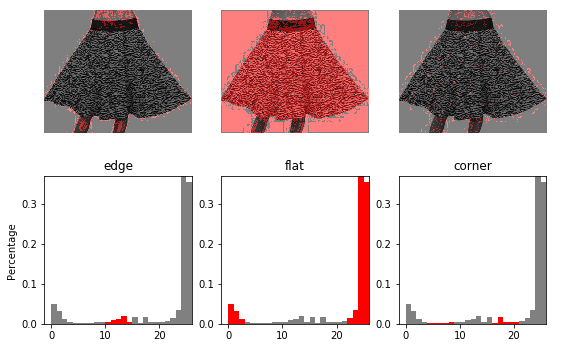

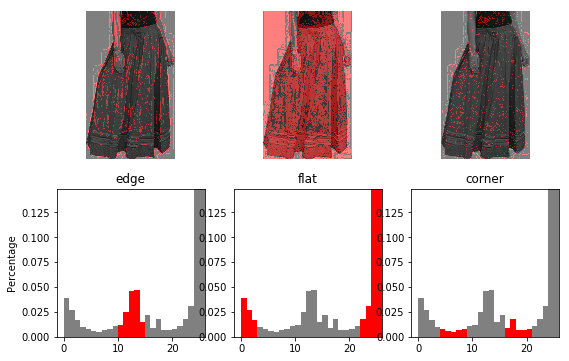

In [41]:
for image in glob.glob('dataset/normal/*.jpg'):
    plot_histograms(image)

## k-NN classifier for predicting close up images

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from imutils import paths
import numpy as np
import argparse
import imutils
import cv2
import os

In [4]:
def image_to_feature_vector(image, size=(32, 32)):
    # resize the image to a fixed size, then flatten the image into
    # a list of raw pixel intensities
    return cv2.resize(image, size).flatten()

def extract_color_histogram(image, bins=(8, 8, 8)):
    # extract a 3D color histogram from the HSV color space using
    # the supplied number of `bins` per channel
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
        [0, 180, 0, 256, 0, 256])

    # handle normalizing the histogram if we are using OpenCV 2.4.X
    if imutils.is_cv2():
        hist = cv2.normalize(hist)

    # otherwise, perform "in place" normalization in OpenCV 3 (I
    # personally hate the way this is done
    else:
        cv2.normalize(hist, hist)

    # return the flattened histogram as the feature vector
    return hist.flatten()

In [30]:
# initialize the raw pixel intensities matrix, the features matrix,
# and labels list
rawImages = []
features = []
labels = []

In [31]:
# grab the list of images that we'll be describing
imagePaths = list(paths.list_images('/home/girish/Documents/gitrepos/atlas/ImageClassification/dataset/'))
 

# loop over the input images
for (i, imagePath) in enumerate(imagePaths):
    # load the image and extract the class label (assuming that our
    # path as the format: /path/to/dataset/{class}.{image_num}.jpg
    image = cv2.imread(imagePath)
    label = imagePath.split('/')[-2]

    # extract raw pixel intensity "features", followed by a color
    # histogram to characterize the color distribution of the pixels
    # in the image
    pixels = image_to_feature_vector(image)
    hist = extract_color_histogram(image)

    # update the raw images, features, and labels matricies,
    # respectively
    rawImages.append(pixels)
    features.append(hist)
    labels.append(label)

    # show an update every 1,000 images
    if i > 0 and i % 1000 == 0:
        print("[INFO] processed {}/{}".format(i, len(imagePaths)))

In [32]:
# show some information on the memory consumed by the raw images
# matrix and features matrix
rawImages = np.array(rawImages)
features = np.array(features)
labels = np.array(labels)
print("[INFO] pixels matrix: {:.2f}MB".format(
    rawImages.nbytes / (1024 * 1000.0)))
print("[INFO] features matrix: {:.2f}MB".format(
    features.nbytes / (1024 * 1000.0)))

[INFO] pixels matrix: 1.36MB
[INFO] features matrix: 0.90MB


In [33]:
# partition the data into training and testing splits, using 75%
# of the data for training and the remaining 25% for testing
(trainRI, testRI, trainRL, testRL) = train_test_split(
    rawImages, labels, test_size=0.25, random_state=42)
(trainFeat, testFeat, trainLabels, testLabels) = train_test_split(
    features, labels, test_size=0.25, random_state=42)

In [34]:
# train and evaluate a k-NN classifer on the raw pixel intensities
print("[INFO] evaluating raw pixel accuracy...")
model = KNeighborsClassifier(n_neighbors=1)
model.fit(trainRI, trainRL)
acc = model.score(testRI, testRL)
print("[INFO] raw pixel accuracy: {:.2f}%".format(acc * 100))

[INFO] evaluating raw pixel accuracy...
[INFO] raw pixel accuracy: 90.27%


In [35]:
# train and evaluate a k-NN classifer on the histogram
# representations
print("[INFO] evaluating histogram accuracy...")
model = KNeighborsClassifier(n_neighbors=1)
model.fit(trainFeat, trainLabels)
acc = model.score(testFeat, testLabels)
print("[INFO] histogram accuracy: {:.2f}%".format(acc * 100))

[INFO] evaluating histogram accuracy...
[INFO] histogram accuracy: 81.42%
